# 1. Setup

## 1.1 Installing Dependencies

In [1]:
%pip install tensorflow matplotlib opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1.2 Importing Dependencies

In [2]:
import cv2
import os
import random
import uuid
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Input, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf

## 1.3 Creating Folders

In [3]:
POS_PATH = os.path.join('dataset', 'positive')
NEG_PATH = os.path.join('dataset', 'negative')
ANC_PATH = os.path.join('dataset', 'anchor')


In [4]:
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

# 2 Collect Positives and Anchors


## 2.1 Untar Labelled Images

In [5]:
# !tar -xf lfw.tgz

In [6]:
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         EX_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positives and Anchors

In [7]:
# cap = cv2.VideoCapture(0)
# while cap.isOpened():
#     ret, frame = cap.read()
#     frame = cv2.resize(frame, (250, 250))
#     if cv2.waitKey(1) & 0XFF == ord('a'):
#         imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
#         cv2.imwrite(imgname, frame)

#     if cv2.waitKey(1) & 0XFF == ord('p'):
#         imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
#         cv2.imwrite(imgname, frame)

#     cv2.imshow('Image Collection', frame)

#     if cv2.waitKey(1) & 0XFF == ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

In [8]:
# plt.imshow(frame)

# 3 Load and Preprocess Data

## 3.1 Get Image directories

In [9]:
anchor = tf.data.Dataset.list_files(os.path.join(ANC_PATH, '*.jpg')).take(300)
positive = tf.data.Dataset.list_files(os.path.join(POS_PATH, '*.jpg')).take(300)
negative = tf.data.Dataset.list_files(os.path.join(NEG_PATH, '*.jpg')).take(300)

## 3.2 Create Labelled Dataset

In [10]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

## 3.3 Preprocessing Data

In [11]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img = img/255.0
    return img

## 3.4 Split Dataset

In [12]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [13]:
# data pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [14]:
# training partition
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [15]:
# Testing partition
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Creating Model

## 4.1 Build Embedding Model

In [16]:
def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [17]:
embedding = make_embedding()

In [18]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [19]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

## 4.3 Build Siamese Model

In [20]:
def make_siamese_model():
    input_image = Input(name='input_image', shape=(100, 100, 3))
    validation_image = Input(name='validation_image', shape=(100, 100, 3))

    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image),
                              embedding(validation_image))

    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [21]:
siamese_model = make_siamese_model()

In [22]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_image (InputLayer)  [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'validation_image[0

# 5. Training Model

## 5.1 Setup Loss Function and Optimizer

In [23]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

## 5.2 Establishing Checkpoints

In [24]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [25]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        Y = batch[2]

        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(Y, yhat)

    grad = tape.gradient(loss, siamese_model.trainable_variables)

    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    return loss

## 5.4 Build Training Loop

In [26]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print("\n Epoch {}/{}".format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        r = Recall()
        p = Precision()

        for idx, batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_model(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train Model

In [27]:
EPOCHS = 10

In [28]:
train(train_data, EPOCHS)


 Epoch 1/10
27/27 [==============================] - 864s 31s/step
0.35471866 0.5251142 1.0

 Epoch 2/10
27/27 [==============================] - 706s 26s/step
0.023747385 0.9906977 1.0

 Epoch 3/10
27/27 [==============================] - 745s 28s/step
0.2310952 0.96153843 0.9852217

 Epoch 4/10
27/27 [==============================] - 706s 26s/step
0.004861799 0.9807692 0.99512196

 Epoch 5/10
27/27 [==============================] - 721s 27s/step
0.15541404 0.9714286 0.99512196

 Epoch 6/10
27/27 [==============================] - 720s 27s/step
0.08607793 0.995 1.0

 Epoch 7/10
27/27 [==============================] - 700s 26s/step
0.04076338 1.0 1.0

 Epoch 8/10
27/27 [==============================] - 558s 21s/step
0.16818528 0.9756098 0.9756098

 Epoch 9/10
27/27 [==============================] - 638s 24s/step
0.10060826 0.9905213 1.0

 Epoch 10/10
27/27 [==============================] - 815s 30s/step
0.016275827 0.9728507 1.0


# 6. Evaluating Model


In [29]:
# get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()


In [30]:
# making predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat


1/1 [==============================] - 3s 3s/step


array([[1.1240807e-09],
       [9.8555744e-01],
       [9.9999517e-01],
       [9.1603506e-01],
       [2.1238161e-10],
       [2.7126652e-09],
       [5.3129834e-01],
       [2.4596611e-07],
       [7.5928515e-01],
       [4.7319404e-10],
       [9.9291116e-01],
       [9.5232233e-10],
       [4.6707087e-12],
       [4.5342745e-08],
       [4.4528482e-04],
       [1.5856870e-11]], dtype=float32)

In [31]:
siamese_model.save(os.path.join('model', 'siamese_model.h5'))


In [32]:
model = tf.keras.models.load_model(os.path.join('model', 'siamese_model.h5'), custom_objects={
                                   'L1Dist': L1Dist, 'BinaryCrossEntropy': tf.losses.BinaryCrossentropy()})


In [33]:
yhat = model.predict([test_input, test_val])
yhat

1/1 [==============================] - 6s 6s/step


array([[1.1240807e-09],
       [9.8555744e-01],
       [9.9999517e-01],
       [9.1603506e-01],
       [2.1238161e-10],
       [2.7126652e-09],
       [5.3129834e-01],
       [2.4596611e-07],
       [7.5928515e-01],
       [4.7319404e-10],
       [9.9291116e-01],
       [9.5232233e-10],
       [4.6707087e-12],
       [4.5342745e-08],
       [4.4528482e-04],
       [1.5856870e-11]], dtype=float32)

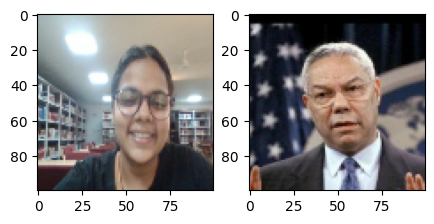

[+] Prediction: Different
-----------------------------------------


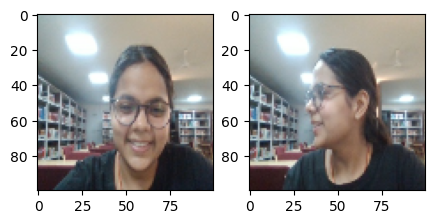

[+] Prediction: Same
-----------------------------------------


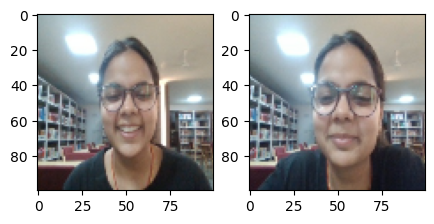

[+] Prediction: Same
-----------------------------------------


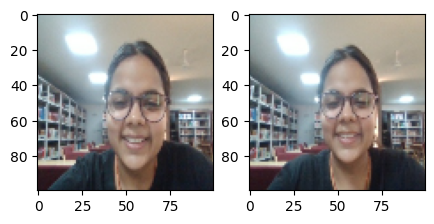

[+] Prediction: Same
-----------------------------------------


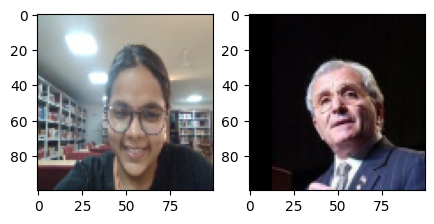

[+] Prediction: Different
-----------------------------------------


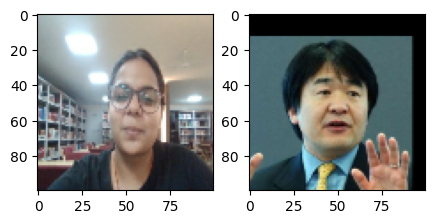

[+] Prediction: Different
-----------------------------------------


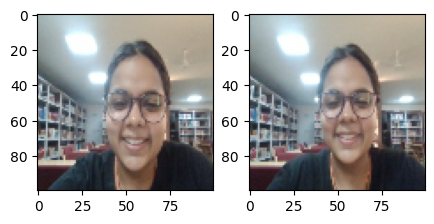

[+] Prediction: Same
-----------------------------------------


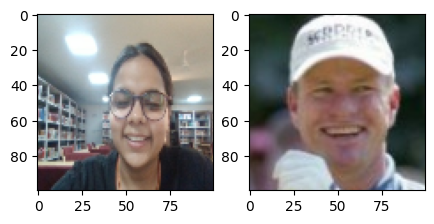

[+] Prediction: Different
-----------------------------------------


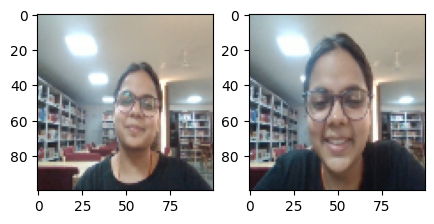

[+] Prediction: Same
-----------------------------------------


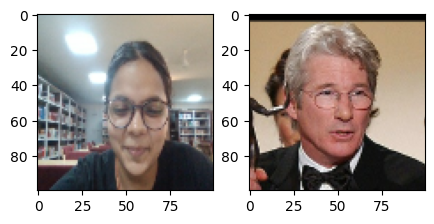

[+] Prediction: Different
-----------------------------------------


In [34]:
# plotting the first 10 results

for i in range(10):
    plt.figure(figsize=(5, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(test_input[i])
    plt.subplot(1, 2, 2)
    plt.imshow(test_val[i])
    plt.show()
    predicted_label = 1 if yhat[i] > 0.5 else 0
    if predicted_label == 1:
        print("[+] Prediction: Same")
        print("-----------------------------------------")
    else:
        print("[+] Prediction: Different")
        print("-----------------------------------------")
